In [8]:
import sys
sys.path.append("/home1/09528/amoac/simulations_code/") 
import gizmo_analysis as gizmo 
import utilities as ut
from fof_analysis import fof

from fof_analysis import star_cluster_imaging
#from fof_analysis import get_gas_star_properties
#from fof_analysis import get_gas_star_indices
#from fof_analysis import preserve_ids
#from fof_analysis import positions_mass_ids
#from fof_analysis import get_gas_star_coordinates
#from fof_analysis import process_first_snapshot

import numpy as np
import pandas as pd
from matplotlib import pylab as plt
from matplotlib import rc #to use Latex math symbols like 'phi'
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import seaborn as sns
from astropy.table import Table
from astropy.io import ascii
import pickle
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colorbar as colorbar
from importlib import reload

b_parsec    = 4
b_kpc       = b_parsec / 1000.
ncut_min    = 5
#age_cut_Myr = 3 #Myr
#age_cut_Gyr = age_cut_Myr / 1000. #Gyr
softening   = 4. #res 7100

simname     = 'm12i_res7100'
simdir      = '/scratch/07428/binod/GalaxiesOnFIRE/cr_suite/m12i_r7100/mhdcv/1Myr/fire2/'

In [9]:
snaps = [621,622,623,624] #set snaps to an arrange of values, goes from 621 to but not including 624 going up by 1

In [10]:
reload(star_cluster_imaging)

<module 'fof_analysis.star_cluster_imaging' from '/home1/09528/amoac/analysis/fof_analysis/star_cluster_imaging.py'>

In [11]:
# Initialize dictionaries to store properties
gas_star_properties_data = {}
part = {}

In [12]:
for snapshot in snaps:
    # Read the snapshot data for the current snapshot
    part[snapshot] = gizmo.io.Read.read_snapshots(['star', 'gas'],'index', snapshot, simulation_directory=simdir, assign_hosts_rotation=True,assign_hosts=True)
    # Get star properties for the current snapshot
    gas_star_properties_data[snapshot] = star_cluster_imaging.get_gas_star_properties(part[snapshot])


# in utilities.simulation.Snapshot():
* reading:  scratch/07428/binod/GalaxiesOnFIRE/cr_suite/m12i_r7100/mhdcv/1Myr/fire2/snapshot_times.txt

  using snapshot index = 621, redshift = 0.005


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  scratch/07428/binod/GalaxiesOnFIRE/cr_suite/m12i_r7100/mhdcv/1Myr/fire2/output/snapdir_621/snapshot_621.0.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 70514272 particles
    dark2     (id = 2): 5513331 particles
    gas       (id = 0): 55666788 particles
    star      (id = 4): 15319821 particles
    blackhole (id = 5): 0 particles

* reading the following
  species: ['star', 'gas']
  gas properties: ['acceleration', 'density', 'electron.fraction', 'hydrogen.neutral.fraction', 'id', 'id.child', 'id.generation', 'magnetic.field', 'mass', 'massfraction', 'photon.energy', 'position', 'potential', 'sfr', 'size', 'temperature', 'velocity']

* reading particles from:
    snapshot_621.0.hdf5
    snapshot_6

In [18]:
# Process the snapshots to get initial cluster information
cluster_select = 1
first_snapshot_data = star_cluster_imaging.process_first_snapshot(gas_star_properties_data[snaps[0]],age_cut_Myr=2, age_cut_Min_Myr=1, cluster_select = cluster_select )

linking length  0.004
min number particles in group  5
0.03341794013977051 seconds
number of groups 9
max number in a group 27


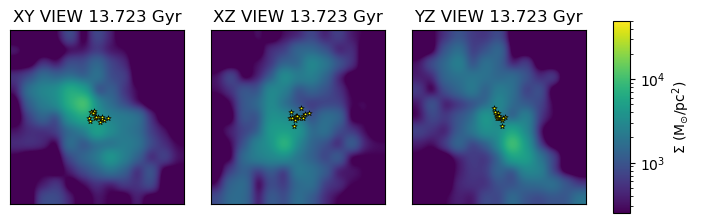

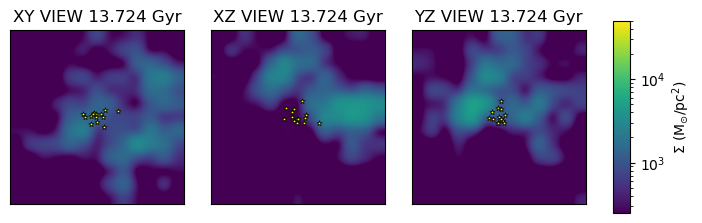

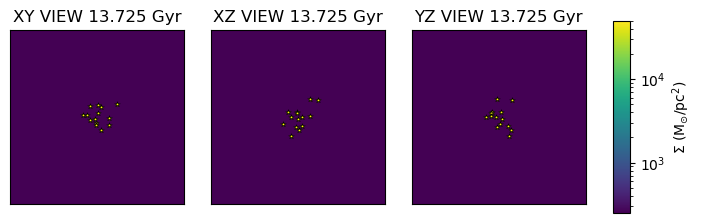

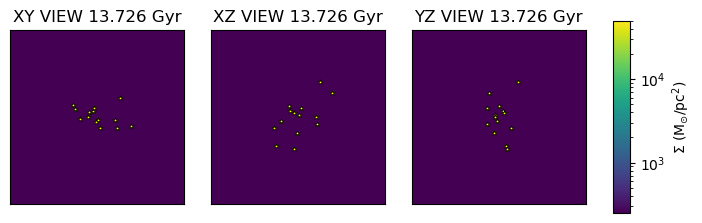

In [19]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colorbar as colorbar
from matplotlib.colors import LogNorm
import numpy as np

# Initialize with the first snapshot data
#xcm1 = first_snapshot_data['sxcm'][0]
#ycm1 = first_snapshot_data['sycm'][0]
#zcm1 = first_snapshot_data['szcm'][0]

pc_width = 40
kpc_width = pc_width/1e3
# Set the desired color bar limits
vmin_value = 2.5e2  # Minimum value for the color bar
#vmin_value = 1
vmax_value = 5e4  # Maximum value for the color bar

for index in range(len(snaps)):
    snapshot = snaps[index]
    gs = gas_star_properties_data[snapshot]
   
    s_loc = star_cluster_imaging.preserve_ids(
        first_snapshot_data['ids_cluster'],
        first_snapshot_data['id_generation_cluster'],
        first_snapshot_data['id_child_cluster'], 
        gs['ids'], 
        gs['id_generation'],
        gs['id_child']
    )

    cluster_info = star_cluster_imaging.find_new_snap_info(s_loc, gs)

    mass_cluster = cluster_info['mass_cluster']
    x_cluster = cluster_info['x_cluster']
    y_cluster = cluster_info['y_cluster']
    z_cluster = cluster_info['z_cluster']
    
    if index == 0:
        # Use the initial xcm1, ycm1, zcm1 for the first snapshot
        xcm1 = first_snapshot_data['sxcm'][cluster_select]
        ycm1 = first_snapshot_data['sycm'][cluster_select]
        zcm1 = first_snapshot_data['szcm'][cluster_select]
    else:
        # Update xcm1, ycm1, zcm1 for subsequent snapshots
        xcm1 = np.average(x_cluster, weights=mass_cluster)
        ycm1 = np.average(y_cluster, weights=mass_cluster)
        zcm1 = np.average(z_cluster, weights=mass_cluster)
        
    #print(xcm1)
    #print(ycm1)
    #print(zcm1)
    g_ind, s_ind = star_cluster_imaging.get_gas_star_indices(xcm1, ycm1, zcm1, gs, pc_width=pc_width)
    #print(g_ind)
    
    gas_star_coordinates = star_cluster_imaging.gas_star_coordinates(gs, g_ind, x_cluster, y_cluster, z_cluster)

    vel_array_xy, res_xy, extent_xy = star_cluster_imaging.compute_velocity_array_xy(xcm1, ycm1, zcm1, gas_star_coordinates, pc_width=pc_width, stepn=13)
    vel_array_xz, res_xz, extent_xz = star_cluster_imaging.compute_velocity_array_xz(xcm1, ycm1, zcm1, gas_star_coordinates, pc_width=pc_width, stepn=13)
    vel_array_yz, res_yz, extent_yz = star_cluster_imaging.compute_velocity_array_yz(xcm1, ycm1, zcm1, gas_star_coordinates, pc_width=pc_width, stepn=13)

    vel_array_xy= np.where(vel_array_xy < vmin_value, vmin_value, vel_array_xy)
    vel_array_xz= np.where(vel_array_xz < vmin_value, vmin_value, vel_array_xz)
    vel_array_yz= np.where(vel_array_yz < vmin_value, vmin_value, vel_array_yz)
    #PLOTTING IMAGES
    
    # Create a new figure for each snapshot
    fig = plt.figure(figsize=(8, 2.5))
    #gs0 = gridspec.GridSpec(1, 2, width_ratios=[1, 0.1])
    gs0 = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 0.1])
    ax0 = plt.subplot(gs0[0])
    ax1 = plt.subplot(gs0[1])
    ax2 = plt.subplot(gs0[2])
    axcb = plt.subplot(gs0[3])

    # Create the LogNorm object with the desired limits
    norm1 = LogNorm(vmin=vmin_value, vmax=vmax_value)

    # Use the same norm1 object in the ColorbarBase function
    cb = colorbar.ColorbarBase(axcb, norm=norm1)
    cb.set_label('$\Sigma$ (M$_{\odot}$/pc$^2$)')
    
    # Use the norm1 object in the imshow function
    
    
    #ax0.scatter(gas_star_coordinates['g_xs'],gas_star_coordinates['g_ys'],edgecolors='red', facecolors='red', s = 10)
    
    # Plot the stars
    #ax0.scatter(gas_star_coordinates['s_xs'],gas_star_coordinates['s_ys'], s=15, marker='*',  edgecolors='black', facecolors='yellow', linewidth=0.5) #All nearby stars without filter
    ax0.imshow(vel_array_xy.T / ((res_xy * 1000.) ** 2), interpolation='gaussian', norm=norm1, extent=extent_xy, origin='lower')
    ax0.scatter(x_cluster, y_cluster, s=15, marker='*', edgecolors='black', facecolors='yellow', linewidth=0.5)
    ax0.get_xaxis().set_visible(False)
    ax0.get_yaxis().set_visible(False)
    ax0.set_xlim(xcm1 - kpc_width, xcm1 + kpc_width)
    ax0.set_ylim(ycm1 - kpc_width, ycm1 + kpc_width)
    ax0.set_xlabel('X')
    ax0.set_ylabel('Y')

    ax1.imshow(vel_array_xz.T / ((res_xz * 1000.) ** 2), interpolation='gaussian', norm=norm1, extent=extent_xz, origin='lower')
    ax1.scatter(x_cluster, z_cluster, s=15, marker='*', edgecolors='black', facecolors='yellow', linewidth=0.5)
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    ax1.set_xlim(xcm1 - kpc_width, xcm1 + kpc_width)
    ax1.set_ylim(zcm1 - kpc_width, zcm1 + kpc_width)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')

    ax2.imshow(vel_array_yz.T / ((res_yz * 1000.) ** 2), interpolation='gaussian', norm=norm1, extent=extent_yz, origin='lower')
    ax2.scatter(y_cluster, z_cluster, s=15, marker='*', edgecolors='black', facecolors='yellow', linewidth=0.5)
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    ax2.set_xlim(ycm1 - kpc_width, ycm1 + kpc_width)
    ax2.set_ylim(zcm1 - kpc_width, zcm1 + kpc_width)
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    
    #reading in snapshot_times.txt file to get snapshot numbers and times
    # columns are: snapshot scale-factor redshift time[Gyr] time_width[Myr]
    snapshot_times = simdir +'/snapshot_times.txt'
    snapnumber = snaps[index] #the particular snapshot we're looking at right now

    snaptime_data = np.genfromtxt(snapshot_times, usecols=(0,3), skip_header=4, dtype=float) #the first and fourth columns are the only ones we need 
    snaps1 = np.array(snaptime_data[:,0]) #col1 = first column saved from text file
    times = np.array(snaptime_data[:,1]) #col4 = second column saved

    snaptime = times[np.where(snaps1 == snapnumber)][0] #time of snapshot in Gyr
    #print(f'{snaptime:.3f}') #this format saves 3 places after the decimal
    title = f'{snaptime:.3f}' + ' Gyr'
    ax0.set_title(f'XY VIEW {title}')
    ax1.set_title(f'XZ VIEW {title}')
    ax2.set_title(f'YZ VIEW {title}')

    # Save or display the figure
    #plt.savefig(f'andrew_gmc_cluster_{snapshot}.pdf', bbox_inches='tight')
    plt.show()
    plt.close(fig)
